In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from calendar import isleap
from utils.time import convert_to_decimal_year, convert_to_datetime
from utils.data import zero_pad

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


Emissions Case: The emissions cases we use for our Pathways to Paris analysis are the same as those used our Taking Stock 2023 baseline. 
In our Low Emissions pathway, we pair low-cost clean energy technologies with our central oil and gas price trajectories and baseline GDP growth. 
In our Mid Emissions pathway, we pair central-cost clean energy technologies with our central oil and gas price trajectories and baseline GDP growth. 
In our High Emissions pathway, we pair central-cost clean energy technologies with low-cost oil and gas prices and high GDP growth.


In [120]:
brent_df = pd.read_csv("/Volumes/Samsung_T5/data/oilgas/BrentOilPrices.csv")
# data from https://www.usinflationcalculator.com
usd_df = pd.read_csv("/Volumes/Samsung_T5/data/conversion_factors_to_2023_dollars.csv")

In [121]:
from utils.time import convert_multiple_formats_to_datetime
from typing import List


def convert_multiple_formats_to_datetime(x, formats: List[str] = ["%Y-%m-%d"]):
    for f in formats:
        try:
            return convert_to_datetime(x, fmt=f)
        except:
            continue
    return x


brent_df["date"] = [
    convert_multiple_formats_to_datetime(x, formats=["%d-%b-%y", "%b %d, %Y"])
    for x in brent_df["Date"]
]
brent_df["year"] = [int(d.year) for d in brent_df["date"]]

In [122]:
brent_df = brent_df.merge(usd_df, on="year")
brent_df["usd_2023"] = brent_df["Price"] * brent_df["conversion_factor_to_2023_dollars"]

<Axes: xlabel='usd_2023', ylabel='Count'>

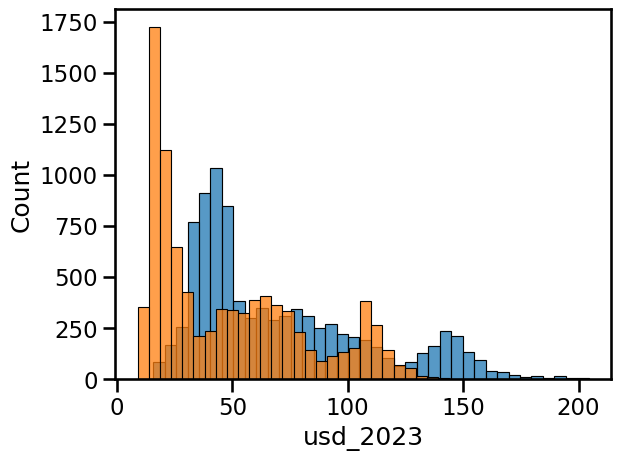

In [123]:
sns.histplot(data=brent_df, x="usd_2023")
sns.histplot(data=brent_df, x="Price")

In [126]:
brent_df.usd_2023.quantile(0.50)

56.3037

<Axes: ylabel='Count'>

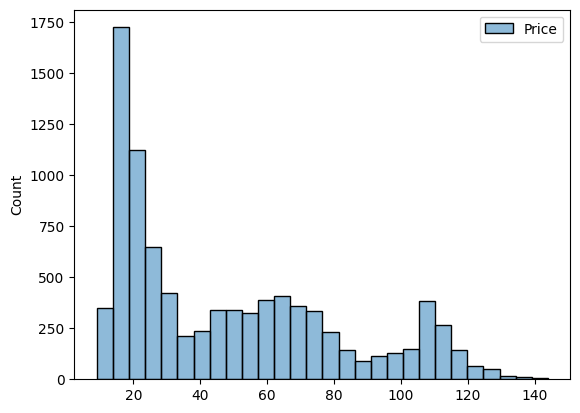

In [49]:
sns.histplot(data=brent_df)

In [ ]:
import sqlite3

try:
    sqliteConnection = sqlite3.connect("SQLite_Python.db")
    cursor = sqliteConnection.cursor()
    print("Database created and Successfully Connected to SQLite")

    sqlite_select_Query = "select sqlite_version();"
    cursor.execute(sqlite_select_Query)
    record = cursor.fetchall()
    print("SQLite Database Version is: ", record)
    cursor.close()

except sqlite3.Error as error:
    print("Error while connecting to sqlite", error)
finally:
    if sqliteConnection:
        sqliteConnection.close()
        print("The SQLite connection is closed")

In [ ]:
con = sqlite3.connect("garland.db")
cursor = con.cursor()

In [ ]:
cursor.execute(
    """
create table dogs (
id int, 
name varchar(255), 
breed varchar(255)
); 
"""
)

In [ ]:
cursor.execute(
    """ insert into dogs (id,name,breed)
values (1,'bella','goldendoodle')"""
)

In [ ]:
obj = cursor.execute("""select * from dogs""")

In [ ]:
df = pd.read_sql_query("select * from dogs", con)

In [ ]:
df = pd.DataFrame(
    {
        "id": [1, 2],
        "name": ["bella", "daisy"],
        "breed": ["goldendoodle", "miniature poodle"],
    },
    index=[0, 1],
)

In [ ]:
df.to_sql("dogs2", con, if_exists="append")

In [ ]:
pd.read_sql_query("select * from dogs2", con)

In [ ]:
pandas.read_sql_query(
    sql,
    con,
    index_col=None,
    coerce_float=True,
    params=None,
    parse_dates=None,
    chunksize=None,
    dtype=None,
    dtype_backend=_NoDefault.no_default,
)[source]

In [5]:
import sys

print(sys.path)
sys.path.append("/Users/lindseygulden/dev/leg-up/utils")

['/Users/lindseygulden/dev/leg-up/projects/weather/notebooks', '/Users/lindseygulden/dev', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/lindseygulden/Library/Caches/pypoetry/virtualenvs/projects-rCMx4yDZ-py3.11/lib/python3.11/site-packages', '/Users/lindseygulden/dev/leg-up']


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from calendar import isleap
from utils.time import convert_to_decimal_year

ModuleNotFoundError: No module named 'utils.time'

In [ ]:
df = pd.read_csv(
    "/Users/lindseygulden/dev/leg-up/projects/weather/data/02459_wwo_daily_weather.csv",
    index_col=[0],
)

In [ ]:
df["decimal_year"] = [convert_to_decimal_year(d) for d in df.datetime]

In [ ]:
sns.lineplot(data=df, x="date", y="avg_temp_f")

In [ ]:
d = dt.date(2020, 2, 2)

d.toordinal() - dt.datetime(1947, 1, 1).toordinal()

In [ ]:
d = dt.datetime(1947, 1, 24)
d.year + (d.timetuple().tm_yday - 1) / 365

In [ ]:
365 + isleap(1948)

In [ ]:
import json

import pandas as pd

import os
import sys

sys.path.append("/Users/lindseygulden/dev/leg-up/utils")
from utils.io import yaml_to_dict
import warnings

warnings.filterwarnings("ignore")

import datetime as dt
from projects.weather.wwo_data_reader import DataReader


d = DataReader.create(
    "wwo", "/Users/lindseygulden/dev/leg-up/config/weather/newton_weather.yml"
)

In [ ]:
import pickle

# with open('data.pkl', 'wb') as f:
#    pickle.dump(d,f)

with open("data.pkl", "rb") as f:
    y = pickle.load(f)

In [ ]:
y.raw_data_dict

In [ ]:
y.data_dict.keys()

In [ ]:
y.postprocess_data()

In [ ]:
import datetime as dt

In [ ]:
y.write_data()

In [ ]:
yaml_to_dict("/Users/lindseygulden/dev/leg-up/config/weather/newton_weather.yml")

In [ ]:
y.data_dict["47448"]

In [ ]:
d.write_data()

In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
from projects.utils.data import convert_to_datetime

In [ ]:
convert_to_datetime(dt.date(2020, 1, 3))

In [ ]:
convert_to_datetime(pd.Timestamp(year=2017, month=1, day=1, hour=12))

In [ ]:
convert_to_datetime(np.datetime64(12013103, "s"))

In [ ]:
d = dt.datetime(2020, 1, 1)
d.to_pydatetime()

In [ ]:
payload = {
    "key": api_key,
    "date": start_date,
    "enddate": end_date,
    "q": location_list[0],
}

In [ ]:
dict([[1, 2], [2, 3]])

In [ ]:
api_key = "cbcffe5648e04b07afa203548241202"
start_date = "01-JAN-2020"
end_date = "31-JAN-2020"
timeout_seconds = 30
frequency = 24
location_list = ["47448"]
response = requests.get(
    f"https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={api_key}&date={start_date}&enddate={end_date}&q={location_list[0]}&tp=1&format=json&includelocation=yes"
)

In [ ]:
j = response.json()

df = pd.DataFrame.from_dict(j)

In [ ]:
df.loc["nearest_area", :].values[0][0]

In [ ]:
n_entries = len(df.loc["weather",]["data"])
w_list = []
for d in range(n_entries):
    w_list.append(df.loc["weather",]["data"][d])

all_weather_df = pd.DataFrame(w_list)

In [ ]:
data_renaming_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up/projects/weather/config/data_description.yml"
)
from itertools import chain

mylist = [list(data_renaming_dict[k].keys()) for k in data_renaming_dict.keys()]
list(chain.from_iterable(mylist))

In [ ]:
for key, value in new_dict.items():
    all_weather_df[key] = value

all_weather_df

In [ ]:
daily_weather_vars = [
    "date",
    "maxtempC",
    "maxtempF",
    "mintempC",
    "mintempF",
    "avgtempC",
    "avgtempF",
    "totalSnow_cm",
    "sunHour",
    "uvIndex",
]
astronomy_vars = [
    "sunrise",
    "sunset",
    "moonrise",
    "moonset",
    "moon_phase",
    "moon_illumination",
]
hourly_vars = [
    "time",
    "tempC",
    "tempF",
    "windspeedMiles",
    "windspeedKmph",
    "winddirDegree",
    "winddir16Point",
    "weatherCode",
    "weatherDesc",
    "precipMM",
    "precipInches",
    "humidity",
    "visibility",
    "visibilityMiles",
    "pressure",
    "pressureInches",
    "cloudcover",
    "HeatIndexC",
    "HeatIndexF",
    "DewPointC",
    "DewPointF",
    "WindChillC",
    "WindChillF",
    "WindGustMiles",
    "WindGustKmph",
    "FeelsLikeC",
    "FeelsLikeF",
    "uvIndex",
]
extract_weather_desc = False
if "weatherDesc" in hourly_vars:
    hourly_vars = [x for x in hourly_vars if x != "weatherDesc"]
    extract_weather_desc = True

In [ ]:
mydict = {
    "locations": ["02459"],
    "api_key": "cbcffe5648e04b07afa203548241202",
    "entry_point": "https://api.worldweatheronline.com/premium/v1/past-weather.ashx",
    "start_date": "01-JAN-2020",
    "end_date": "31-DEC-2022",
    "timeout_seconds": 30,
    "frequency": 24,
    "daily_weather_variables": [
        "date",
        "maxtempC",
        "maxtempF",
        "mintempC",
        "mintempF",
        "avgtempC",
        "avgtempF",
        "totalSnow_cm",
        "sunHour",
        "uvIndex",
    ],
}

In [ ]:
from schema import Schema, And, Use, Optional, SchemaError
import yaml
import validators

schema = Schema(
    {
        "locations": And(list, lambda x: all([isinstance(xx, str) for x in xx])),
        "api_key": And(str),
        Optional(
            "entry_point",
            default="https://api.worldweatheronline.com/premium/v1/past-weather.ashx",
        ): And(str, lambda x: validators.url(x)),
        "end_date": And(str, lambda x: len(x) == 11),
        "start_date": And(str, lambda x: len(x) == 11),
        Optional("timeout_seconds", default=30): And(int, lambda t: t > 0),
        Optional("frequency", default=1): And(lambda f: f in [1, 3, 6, 12, 24], int),
        "daily_weather_variables": And(
            list,
            lambda x: all(
                [
                    xx
                    in [
                        "date",
                        "maxtempC",
                        "maxtempF",
                        "mintempC",
                        "mintempF",
                        "avgtempC",
                        "avgtempF",
                        "totalSnow_cm",
                        "sunHour",
                        "uvIndex",
                    ]
                    for xx in x
                ]
            ),
        ),
        "astronomy_variables": And(
            list,
            lambda x: all(
                [
                    xx
                    in [
                        "sunrise",
                        "sunset",
                        "moonrise",
                        "moonset",
                        "moon_phase",
                        "moon_illumination",
                    ]
                    for xx in x
                ]
            ),
        ),
        "hourly_variables": And(
            list,
            lambda x: all(
                [
                    xx
                    in [
                        "time",
                        "tempC",
                        "tempF",
                        "windspeedMiles",
                        "windspeedKmph",
                        "winddirDegree",
                        "winddir16Point",
                        "weatherCode",
                        "weatherDesc",
                        "precipMM",
                        "precipInches",
                        "humidity",
                        "visibility",
                        "visibilityMiles",
                        "pressure",
                        "pressureInches",
                        "cloudcover",
                        "HeatIndexC",
                        "HeatIndexF",
                        "DewPointC",
                        "DewPointF",
                        "WindChillC",
                        "WindChillF",
                        "WindGustMiles",
                        "WindGustKmph",
                        "FeelsLikeC",
                        "FeelsLikeF",
                        "uvIndex",
                    ]
                    for xx in x
                ]
            ),
        ),
    }
)

In [ ]:
df

In [ ]:
weather = json.loads(response.content.decode("utf-8"))["data"]["weather"]

weather_list = []

for i in range(len(weather)):
    weather_dict = {k: weather[i][k] for k in tuple(daily_weather_vars)}
    weather_dict.update(
        {k: weather[i]["astronomy"][0][k] for k in tuple(astronomy_vars)}
    )
    for h in range(len(weather[i]["hourly"])):
        weather_dict.update({k: weather[i]["hourly"][h][k] for k in tuple(hourly_vars)})
        if extract_weather_desc:
            weather_dict.update(
                {"weatherDesc": weather[i]["hourly"][h]["weatherDesc"][0]["value"]}
            )
        weather_list.append(weather_dict.copy())
weather_df = pd.DataFrame(weather_list)

In [ ]:
weather_df.date.value_counts()

In [ ]:
with open("/Users/lindseygulden/dev/leg-up/data/newton_tp1.json", "wb") as fd:
    for chunk in response.iter_content(chunk_size=128):
        fd.write(chunk)

In [ ]:
# df = pd.read_json("/Users/lindseygulden/dev/leg-up/data/newton_tp24.json")
df = pd.read_json("/Users/lindseygulden/dev/leg-up/data/newton_tp1.json")
df

In [ ]:
h_list = []
w_list = []
n_entries = len(df.loc["weather",]["data"])
for d in range(n_entries):
    w_list.append(df.loc["weather",]["data"][d])

all_weather_df = pd.DataFrame(w_list)
forecast_vars = [
    "date",
    "maxtempF",
    "mintempF",
    "avgtempF",
    "totalSnow_cm",
    "sunHour",
    "uvIndex",
]

In [ ]:
n_hours = all_weather_df.loc[0, "hourly"]

In [ ]:
import yaml

with open(
    "/Users/lindseygulden/dev/leg-up/projects/weather/config/data_description.yml", "r"
) as f:
    try:
        tmp = yaml.safe_load(f)
    except yaml.YAMLError as e:
        print(e)

In [ ]:
import yaml
import datetime as dt

with open("../../test.yml", "w") as f:
    yaml.dump({"d": {"first": dt.datetime(2001, 1, 1)}}, f, default_flow_style=False)

In [ ]:
with open("../../config.yml", "w") as outfile:
    yaml.dump(hourly[0], outfile, default_flow_style=False)

In [ ]:
daily_weather_vars = [
    "date",
    "maxtempC",
    "maxtempF",
    "mintempC",
    "mintempF",
    "avgtempC",
    "avgtempF",
    "totalSnow_cm",
    "sunHour",
    "uvIndex",
]
astronomy_vars = {
    "sunrise": "sunrise_local_time",
    "sunset": "sunset_local_time",
    "moonrise": "moonrise_local_time",
    "moonset": "moonset_local_time",
    "moon_phase": "moon_phase",
    "moon_illumination": "moon_illumination",
}
hourly_vars = [
    "time",
    "tempC",
    "tempF",
    "windspeedMiles",
    "windspeedKmph",
    "winddirDegree",
    "winddir16Point",
    "weatherCode",
    "weatherDesc",
    "precipMM",
    "precipInches",
    "humidity",
    "visibility",
    "visibilityMiles",
    "pressure",
    "pressureInches",
    "cloudcover",
    "HeatIndexC",
    "HeatIndexF",
    "DewPointC",
    "DewPointF",
    "WindChillC",
    "WindChillF",
    "WindGustMiles",
    "WindGustKmph",
    "FeelsLikeC",
    "FeelsLikeF",
    "uvIndex",
]

In [ ]:
all_weather_df.loc[0, "astronomy"]

In [ ]:
h_list = []
w_list = []
for d in range(35):
    w_list.append(df.loc["weather",]["data"][d])

all_weather_df = pd.DataFrame(w_list)
forecast_vars = [
    "date",
    "maxtempC",
    "mintempC",
    "avgtempC",
    "maxtempF",
    "mintempF",
    "avgtempF",
    "totalSnow_cm",
    "sunHour",
    "uvIndex",
]
forecast_df = all_weather_df[forecast_vars]


for d in range(35):
    hourly = all_weather_df.loc[d, "hourly"]
    astronomy = all_weather_df.loc[d, "astronomy"][0]
    today_date = all_weather_df.loc[d, "date"]
    for hour in hourly:
        # add daily variables to hourly variables
        for v in astronomy_vars:
            hour[v] = astronomy[v]
        for v in forecast_vars:
            hour[v] = all_weather_df.loc[d, v]
        h_list.append(hour)
hourly_df = pd.DataFrame(h_list)
hourly_df = hourly_df[daily_weather_vars + hourly_vars]

In [ ]:
hourly_df

In [ ]:
config = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up/config/weather/newton_weather.yml"
)

In [ ]:
hourly_df.date

In [ ]:
all_weather_df.loc[0, forecast_vars]

In [ ]:
all_weather_df.loc[0, "hourly"]

In [ ]:
hourly_df.loc

In [ ]:
for i in hourly_df.columns.values:
    print(f"   - '{i}'")

In [ ]:
import sys

print(sys.path)

import sys
print(sys.path)

In [ ]:
from projects.utils.io import yaml_to_dict

In [ ]:
tmp = pd.DataFrame(w_list)
len(tmp.loc[0, "hourly"])